<b> <font size="+2.5"> Selection of covariates for differential expression analysis
 </b> </font> <br>

Date: 2023-11-21 <br>
Author: ASF

# Load libraries

In [1]:
### Set up
suppressPackageStartupMessages({
library(DESeq2)
library(edgeR)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
library(magrittr)
library(variancePartition)
library(PCAtools)
library(rlist)})

# Read in pseudocount matrices from cell types & <br> compute full pseudobulk count matrix

see script 02_make_pseudobulk to obtain files

In [2]:
# make a list of all the file names you want to read in 
files <- list.files(path="../datasets/PseudoBulkFinal", pattern="^.[^L].*matrix.tsv$", full.names=T)

#read in all count matrices of all cell types and put in a list object
#make temporary object (tmp) to assign the rownames with individual and remove 
#first and second column that is not count data and transpose using t
counts_list=lapply(files, function(x) { 
  tmp=base::as.data.frame(read.delim(x, sep='\t', head=T))
  rownames(tmp)=tmp[,2] 
  return( base::as.data.frame(t( tmp[,-c(1:2)])) )
} 
)

#assign the names of the cell types to the corresponding list in the object counts list
names(counts_list)=gsub(files, pattern="^.*PseudoBulkFinal.|_pseudobulk.*$", replacement="")

summary(counts_list)

                Length Class      Mode
Astro_FB        87     data.frame list
Astro_PP        87     data.frame list
Endothelial     87     data.frame list
Exc_L2-3        87     data.frame list
Exc_L3-5        87     data.frame list
Exc_L4-6_1      87     data.frame list
Exc_L4-6_2      87     data.frame list
Exc_L4-6_3      85     data.frame list
Exc_L5-6_1      86     data.frame list
Exc_L5-6_2      82     data.frame list
Exc_L5-6_HTR2C  85     data.frame list
In_LAMP5_1      87     data.frame list
In_LAMP5_2      87     data.frame list
In_PVALB_Ba     87     data.frame list
In_PVALB_Ch     87     data.frame list
In_RELN         87     data.frame list
In_SST          87     data.frame list
In_VIP          87     data.frame list
Microglia       87     data.frame list
Oligodendrocyte 87     data.frame list
OPC             87     data.frame list

In [3]:
celltypes <- names(counts_list)
list_of_individuals <- colnames(counts_list[['Astro_FB']])
#length(list_of_individuals)


# of each cell type select one specific individual and put in a dataframe
# then sum the rows (gene expression values of a specific gene) -> full pseudobulk counts per individual
full_pseudo_counts <- list()
#calculate full_bulk by summing all reads per gene per individual
for (individual in list_of_individuals){
  full_pseudo_counts[[individual]] <- data.frame(matrix(ncol = 0, nrow = 26195))
  for (celltype in celltypes){
    tmp <- counts_list[[celltype]] %>% dplyr::select(any_of(individual))
    full_pseudo_counts[[individual]] <- cbind(full_pseudo_counts[[individual]], tmp)
    full_pseudo_counts[[individual]] <- as.data.frame(rowSums(full_pseudo_counts[[individual]]))
    colnames(full_pseudo_counts[[individual]]) <- c(individual)}
}

# cbind all elements of the full_pseudo_counts list using list.cbind()
# resulting in a dataframe where each column represents one individual
full_bulk_counts <- list.cbind(full_pseudo_counts)
dim(full_bulk_counts)
#head(full_bulk_counts)

[1] 26195    87

In [4]:
# save object
save(full_bulk_counts, file = "../datasets/full_pseudobulk_counts.RData")

# Read in metadata

In [5]:
meta_data <- as.data.frame(read.delim("../datasets/adata.obs_20231120.tsv", sep='\t'))

In [6]:
#select columns of interest
meta_data_subset <- meta_data[c("sample","individual","Age", "AgeBin", "Sex", "Status", "RIN", "Brain.pH", "PMI", "X6.Batch", 
                                'Suicide', "Freezer.storage.time..days.", 'Agonal.score', 'Classification')]

#keep only unique observations (one line per individual)
meta_data_subset <- meta_data_subset %>% distinct(individual, .keep_all=TRUE)

meta_data_subset$Status <- as.character(meta_data_subset$Status)
meta_data_subset$Disease_Status <- ifelse(meta_data_subset$Status=='0', 'Controls', 'Cases')
meta_data_subset$Disease_Status <- factor(meta_data_subset$Disease_Status, levels=c('Controls', 'Cases'))

dim(meta_data_subset)
#head(meta_data_subset)

[1] 87 15

In [7]:
# Set missing RIN to median
meta_data_subset$RIN[is.na(meta_data_subset$RIN)] <- median(meta_data_subset$RIN, na.rm=TRUE) 

#change column names
colnames(meta_data_subset)[which(names(meta_data_subset) == 'Brain.pH')] <- 'pH'
colnames(meta_data_subset)[which(names(meta_data_subset) == 'X6.Batch')] <- 'lib_batch'
meta_data_subset$lib_batch <- as.character(meta_data_subset$lib_batch)
colnames(meta_data_subset)[which(names(meta_data_subset) == 'Freezer.storage.time..days.')] <- 'Days_in_Freezer'
colnames(meta_data_subset)[which(names(meta_data_subset) == 'Agonal.score')] <- 'agonal_score'

# order by individual identifier (descending)
meta_data_subset <- meta_data_subset[order(meta_data_subset$individual),]
#head(meta_data_subset)

#check that order of the individuals in meta data and in full_bulk_counts is the same
#unique(colnames(full_bulk_counts) == meta_data_subset$individual)

# Variance stabilisation transformation

In [8]:
# Keep only genes expressed with minimal 10 counts in more than specific percentage (90%) of samples
full_bulk_filt  <- full_bulk_counts[rowSums(full_bulk_counts >= 10) > 78,]
dim(full_bulk_counts)
dim(full_bulk_filt)

[1] 26195    87

[1] 20851    87

converting counts to integer mode



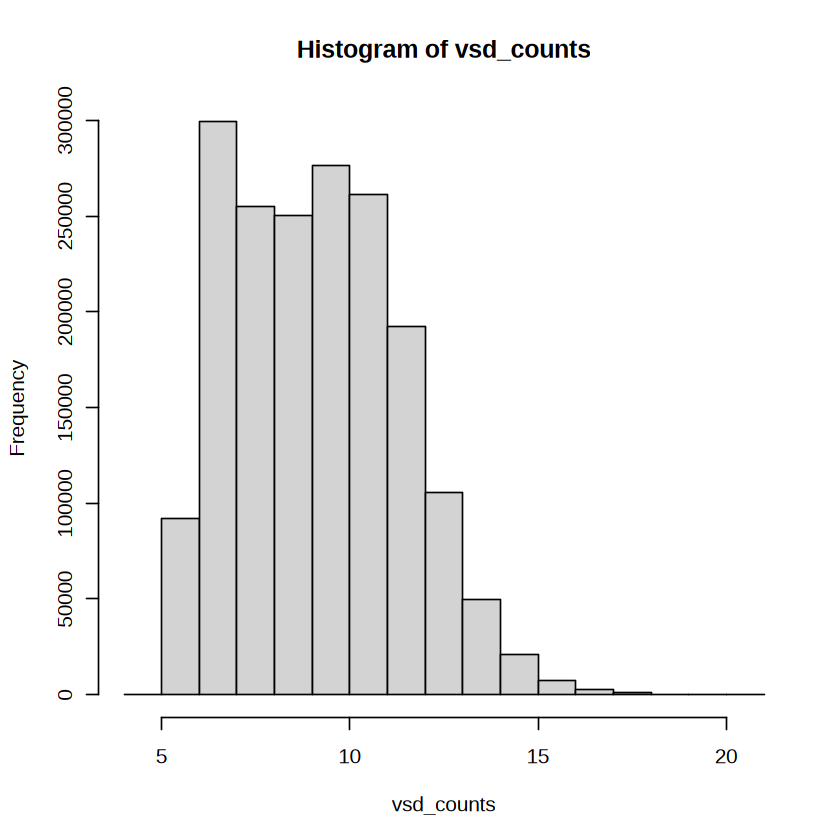

In [9]:
# genes as rows 
# samples as columns
vsd_counts <- DESeq2::varianceStabilizingTransformation(as.matrix(full_bulk_filt))

hist(vsd_counts)

# PCA

In [10]:
rownames(meta_data_subset) <- meta_data_subset$individual

PCA_full_bulk <- pca(vsd_counts, metadata = meta_data_subset, removeVar=0.05)

-- removing the lower 5% of variables based on variance



In [12]:
#head(PCA_full_bulk$rotated)
#head(meta_data_subset)

In [11]:
cov_pc <- data.frame(cbind(meta_data_subset, PCA_full_bulk$rotated[,c(1:10)] ))
#head(cov_pc)

## Scree plot

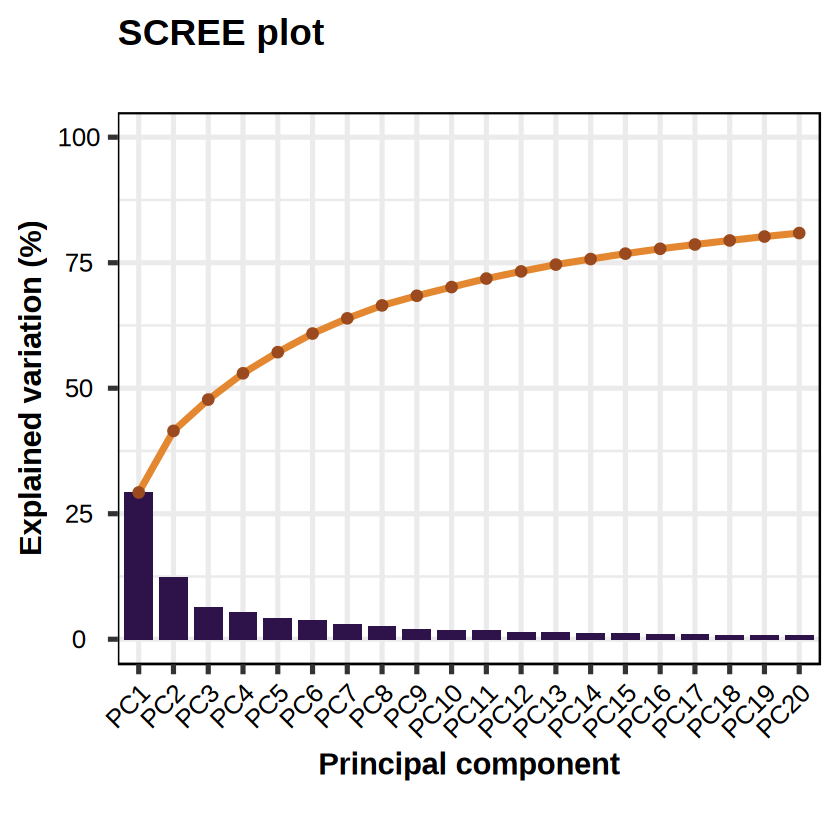

In [12]:
#options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
scree <- screeplot(PCA_full_bulk, components = getComponents(PCA_full_bulk)[1:20], axisLabSize = 18, titleLabSize = 22, colBar = "#2e134b" ,
  drawCumulativeSumLine = TRUE,
  colCumulativeSumLine = "#e38830", colCumulativeSumPoints = "#9a4a1e",
  sizeCumulativeSumPoints = 2.5)
scree + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, colour="black", size=15), axis.text.y = element_text(colour="black", size=15),
             axis.title=element_text(face='bold'))

## Correlation of PCs with metadata

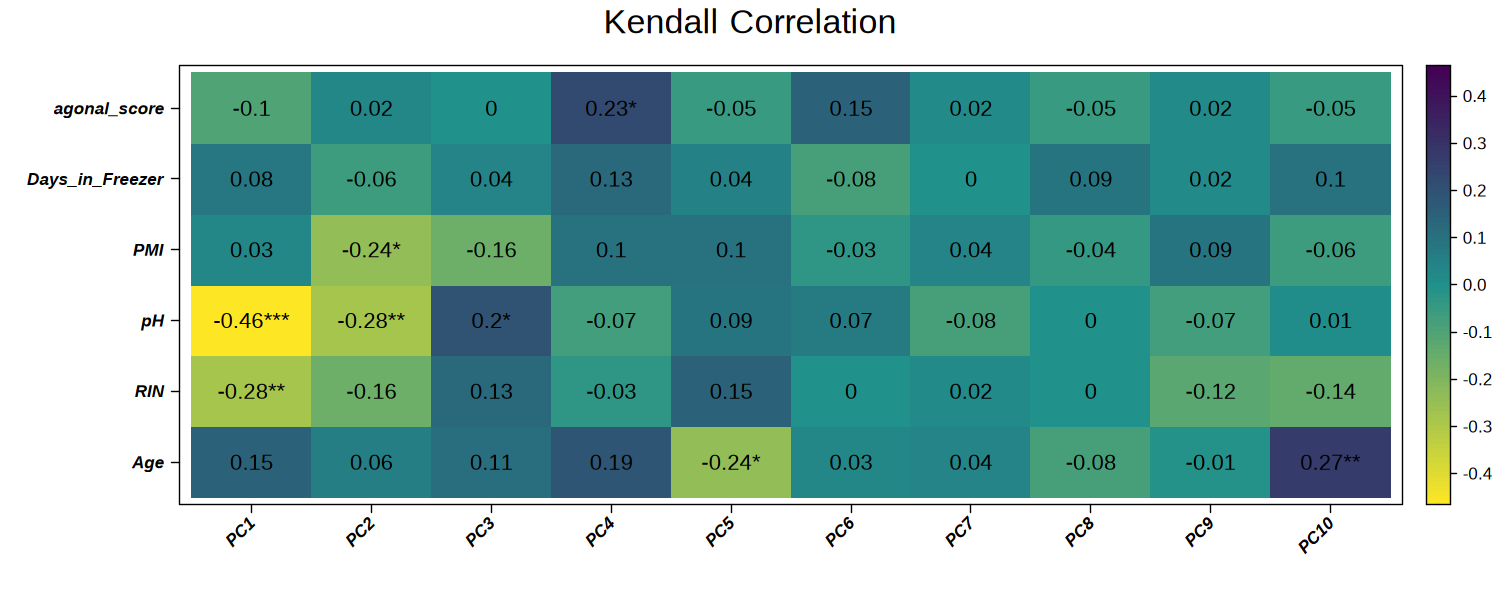

In [13]:
# Correlate principal components to continuous variable metadata and test significancies of these.
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 100)
eigencorplot(PCA_full_bulk, components = getComponents(PCA_full_bulk)[1:10],
             metavars = c('Age', 'RIN', 'pH', 'PMI', 'Days_in_Freezer', 'agonal_score'), rotLabX = 45, cexCorval = 1.3, 
             col = c("#fde725", '#21918c', '#440154'), corFUN = 'kendall', corMultipleTestCorrection = 'BH', 
             main = bquote(Kendall ~ Correlation), colCorval = "black", fontLabX = 4, fontLabY = 4)

# Canonical Correlation Analysis (CCA)

In [14]:
# CCA with PCs fitted on residuals
# analyze correlation of covariates
# canonical correlation analysis CCA
form <- as.formula("~ Disease_Status + Age + Sex + pH + RIN + PMI + lib_batch + 
Suicide + Days_in_Freezer + agonal_score + PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10")
#Manner.of.Death

# Calculate the correlation coefficients
C <- canCorPairs(form, cov_pc)
# C to long format
C_long <- reshape::melt(C)
C_long$X1 <- factor(C_long$X1, levels = colnames(C))
C_long$X2 <- factor(C_long$X2, levels = colnames(C))

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


In [15]:
colors <- c('#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF',
            '#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF','#fde725', '#d0e11c', '#a0da39', '#73d056', '#4ac16d',
            '#2db27d', '#1fa187', '#21918c', '#277f8e', '#2e6e8e', '#365c8d', '#3f4788', '#46327e', '#481b6d', '#440154')

corrplot 0.92 loaded

Warning message in ind1:ind2:
“numerical expression has 15 elements: only the first used”


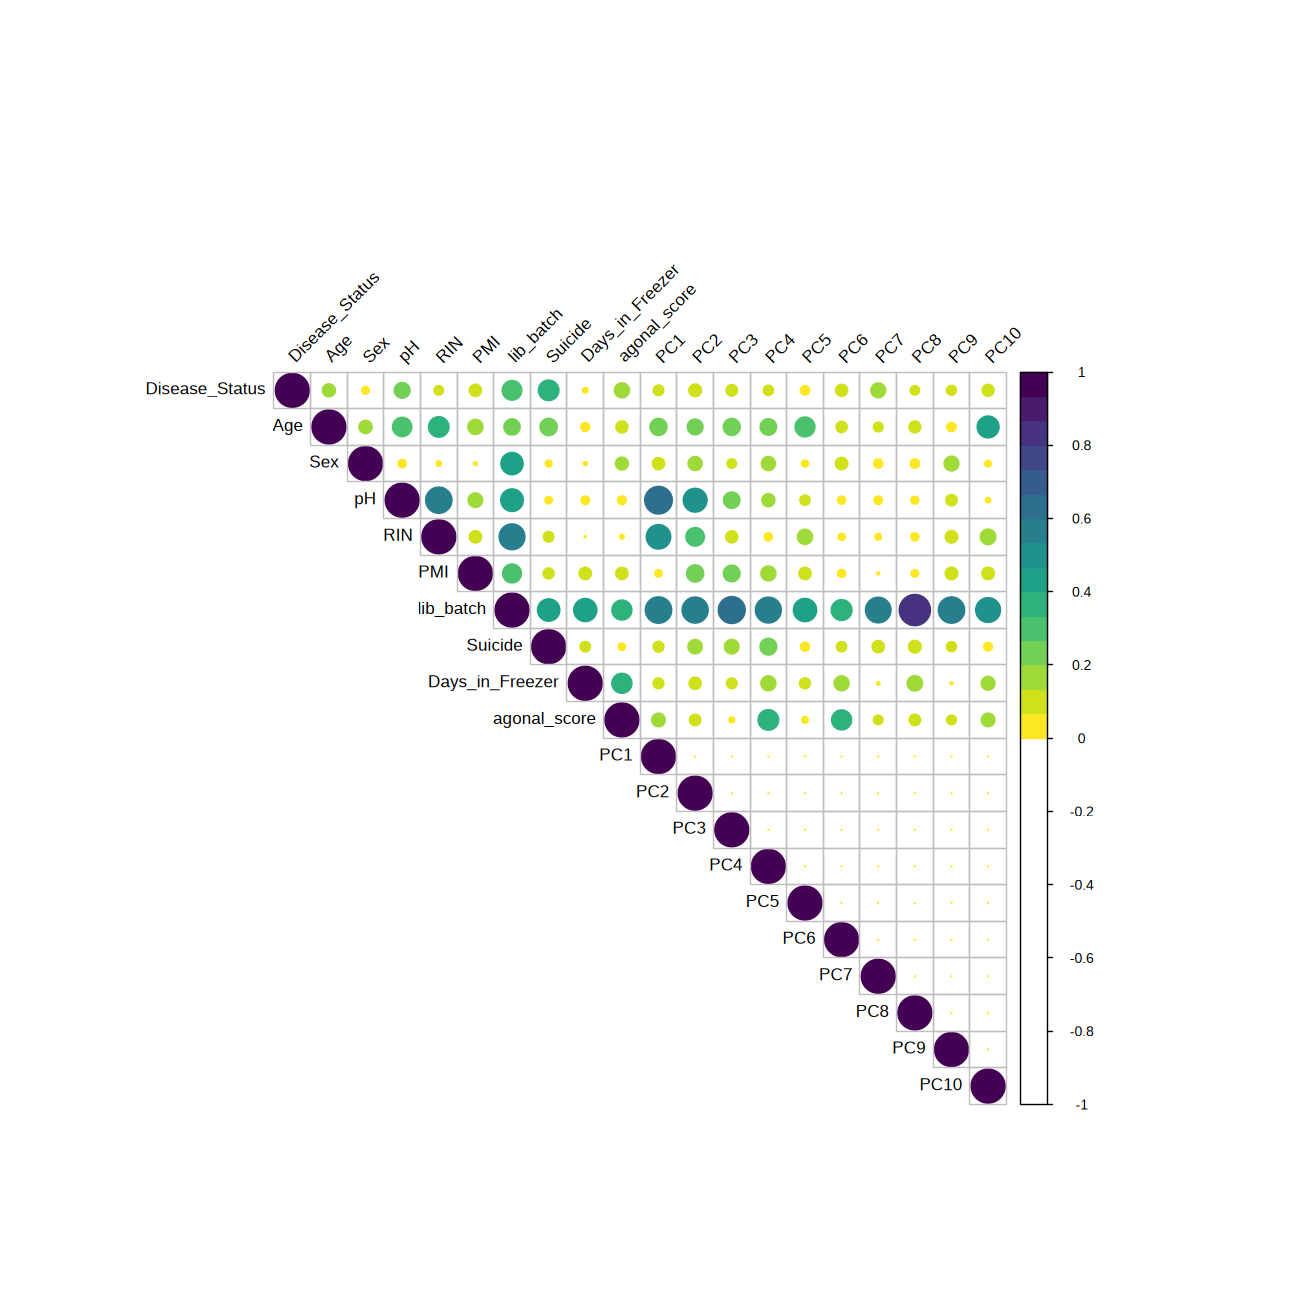

In [16]:
library(corrplot)
options(repr.plot.width = 13, repr.plot.height = 13, repr.plot.res = 100)
corrplot(C, type = "upper", ylim =c(0,1),
         tl.col = "black", tl.srt = 45, col=colors)

# Account for hidden confounders - <br> calculate PC1 on batch corrected count matrix

## filtering, and voom transformation

In [17]:
## Create DGEList object and filter genes

d0 <- DGEList(as.data.frame(full_bulk_counts), samples = meta_data_subset)
dim(d0)

# Filter genes
# cutoff --> which proportion of sample needs to be expressed for gene to be kept
# set here to 0.9 as this is part of quality control and makes sense to be stricter
cutoff_sample <- 0.9

cutoff_counts <- 10
keep <- rowSums(d0$counts >= cutoff_counts) >= cutoff_sample*ncol(d0$counts)
d <- d0[keep,] 
dim(d) # number of genes left #20851

[1] 26195    87

[1] 20851    87

In [18]:
# Normalization factor
# Calculate normalization factors to scale the raw library sizes.
# default method: TMM weighted trimmed mean of M-values proposed by Robinson and Oshlack (2010)
d <- calcNormFactors(d)
#d

In [19]:
# Voom transformation and calculation of variance weights

#What is voom doing?
#Counts are transformed to log2 counts per million reads (CPM), where “per million reads” is defined based on the normalization factors we calculated earlier
#A linear model is fitted to the log2 CPM for each gene, and the residuals are calculated
#A smoothed curve is fitted to the sqrt(residual standard deviation) by average expression (see red line in plot above)
#The smoothed curve is used to obtain weights for each gene and sample that are passed into limma along with the log2 CPMs.

# specify model to fitted

#design matrix with rows corresponding to samples and columns to coefficients to be estimated. Defaults to the unit vector meaning that samples are treated as replicates


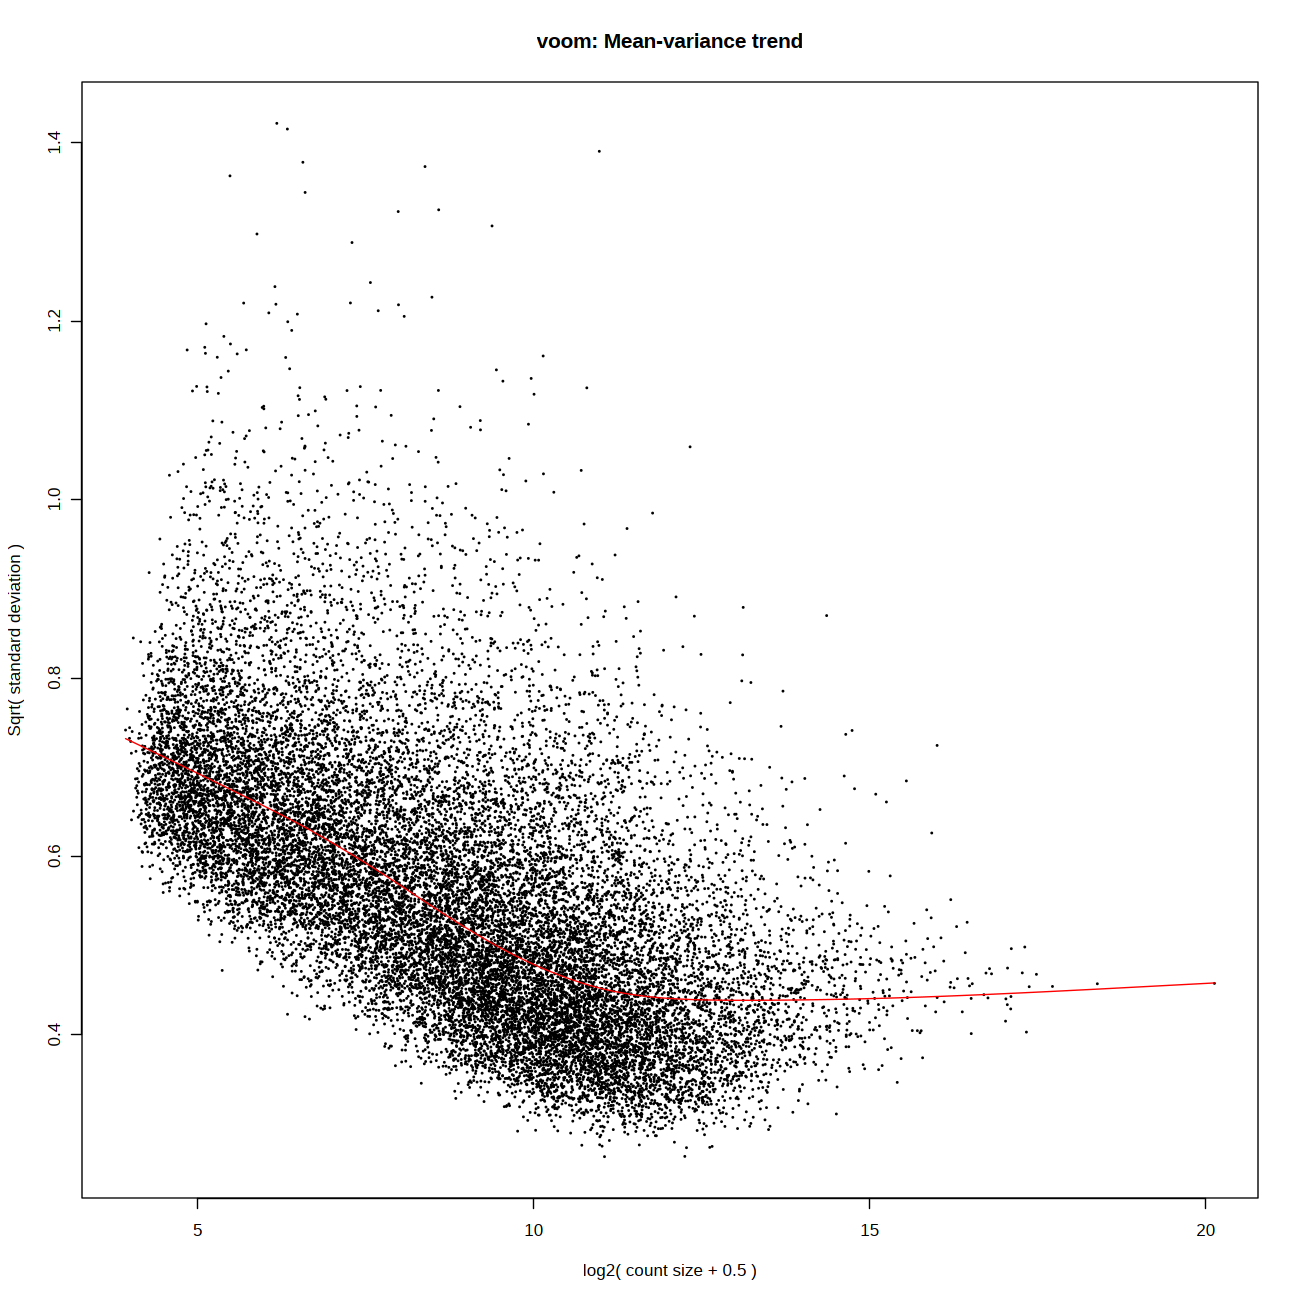

In [20]:
des <- "~ Disease_Status + Sex + Age + pH + RIN + PMI + lib_batch"

# specify model to fitted
mm <- model.matrix(as.formula(des), data = d$samples)

# voom transformation
y <- voom(d, mm, plot = T)

## Remove Batch effects

In [21]:
## define adapted remove batch effects function

# Define own method that is able to remove 3 categorical batch variables
# written by Nathalie Gerstner
remove3BatchEffects <- function(x,batch=NULL,batch2=NULL,batch3=NULL,
                                covariates=NULL,design=matrix(1,ncol(x),1),...)
  #  Remove batch effects from matrix of expression data
  #  Adapted from Gordon Smyth and Carolyn de Graaf
  #  Created 1 Aug 2008. Last revised 1 June 2014.
{
  if(is.null(batch) && is.null(batch2) && is.null(batch3) && is.null(covariates)) return(as.matrix(x))
  if(!is.null(batch)) {
    batch <- as.factor(batch)
    contrasts(batch) <- contr.sum(levels(batch))
    batch <- model.matrix(~batch)[,-1,drop=FALSE]
  }
  if(!is.null(batch2)) {
    batch2 <- as.factor(batch2)
    contrasts(batch2) <- contr.sum(levels(batch2))
    batch2 <- model.matrix(~batch2)[,-1,drop=FALSE]
  }
  if(!is.null(batch3)) {
    batch3 <- as.factor(batch3)
    contrasts(batch3) <- contr.sum(levels(batch3))
    batch3 <- model.matrix(~batch3)[,-1,drop=FALSE]
  }
  if(!is.null(covariates)) covariates <- as.matrix(covariates)
  X.batch <- cbind(batch,batch2,batch3,covariates)
  fit <- lmFit(x,cbind(design,X.batch),...)
  beta <- fit$coefficients[,-(1:ncol(design)),drop=FALSE]
  beta[is.na(beta)] <- 0
  as.matrix(x) - beta %*% t(X.batch)
}

In [22]:
#Remove batch effect
#removeBatchEffect wants a numeric matrix containing log-expression values
#and gives a numeric matrix of log-expression values with batch and covariate effects removed.
# If x contains weights, then these will be used in estimating the batch effects

y2 <- remove3BatchEffects(y, batch = d$samples$lib_batch, batch2 = d$samples$Sex,
                          batch3 = d$samples$Disease_Status,
                          covariates = d$samples[,c("Age", "RIN", "pH", "PMI")])
#head(y2)

## calculate PC1 (hidden noise)

In [23]:
pc <- pca(y2, removeVar = 0.2)
cov_pc <- data.frame(cbind(d$samples, pc$rotated[,c(1:10)] ))
#head(cov_pc)

-- removing the lower 20% of variables based on variance



In [24]:
# save PC1_hidden_confounders

#select columns of interest
PC1_hidden_confounders <- cov_pc[c("individual","PC1")]
colnames(PC1_hidden_confounders) <- c('individual','PC1_hidden_noise')
#head(PC1_hidden_confounders)

library("writexl")
write_xlsx(PC1_hidden_confounders,"../datasets/PC1_hidden_confounders.xlsx", col_names = TRUE)

In [25]:
cov_pc_complete <- merge(cov_pc, PC1_hidden_confounders, by='individual')
rownames(cov_pc_complete) <- cov_pc_complete$individual

# Ext. Data Fig. 10b - Variance Partitioning

In [26]:
des_varPart <- "~ (1|Disease_Status) + (1|Sex) + (1|lib_batch)+ Age + pH + RIN + PMI + PC1_hidden_noise"
form <- as.formula(des_varPart)

In [27]:
# run variance partition
varPart <- fitExtractVarPartModel(vsd_counts, form, cov_pc_complete)

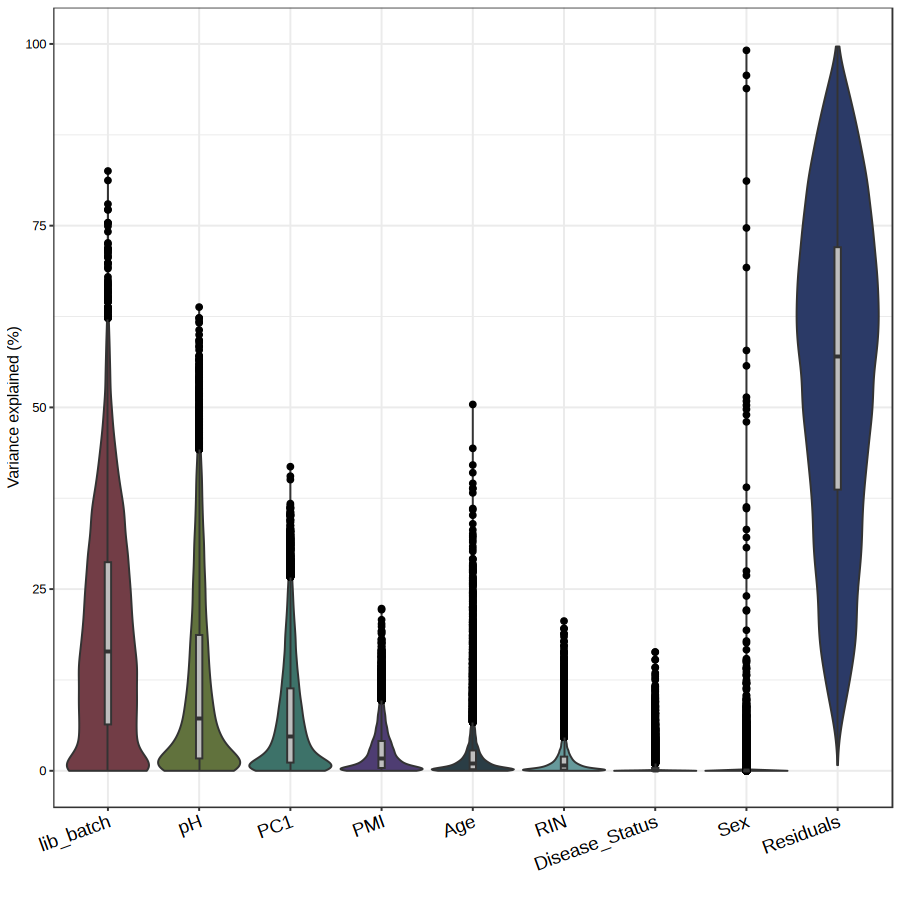

In [28]:
colnames(varPart)[which(names(varPart) == 'PC1_hidden_noise')] <- 'PC1'

vp1 <- sortCols( varPart )

options(repr.plot.width = 9, repr.plot.height = 9, repr.plot.res = 100)
plotVarPart( vp1, col=c('#723D46', '#61723D', '#3D7269', '#4E3D72', '#2A3D45', '#66999B', '#E26D5C', '#E2B05C', '#2B3A67'))

In [29]:
mean(varPart$lib_batch)*100 #18.59
mean(varPart$pH)*100 #11.79
mean(varPart$PC1)*100 #7.24
mean(varPart$PMI)*100 # 2.73
mean(varPart$Age)*100 # 2.27
mean(varPart$RIN)*100 #1.46
mean(varPart$Disease_Status)*100 #0.54
mean(varPart$Sex)*100 # 0.42
mean(varPart$Residuals)*100 # 54.96

[1] 18.58814

[1] 11.78898

[1] 7.239377

[1] 2.728864

[1] 2.272733

[1] 1.457976

[1] 0.542901

[1] 0.4241762

[1] 54.95685

In [30]:
pdf(file = "../figures/Variance_partition_full_pseudobulk_20231121.pdf", 
    width = 6, height = 6)

plotVarPart( vp1, col=c('#723D46', '#61723D', '#3D7269', '#4E3D72', '#2A3D45', '#66999B', '#E26D5C', '#E2B05C', '#2B3A67'))

dev.off()

png 
  2

# Supplementary Table 1, 2

In [31]:
library(readxl)
anonymous_donor_label <- read_excel('../datasets/anonymous_donor_label.xlsx', col_names=T)

In [32]:
# select relevant meta_data
PC1_hidden_confounders$individual <- as.character(PC1_hidden_confounders$individual)
meta_data_subset$individual <- as.character(meta_data_subset$individual)
meta_data_final <- merge(meta_data_subset, PC1_hidden_confounders, by='individual')
meta_data_final <- merge(meta_data_final, anonymous_donor_label, by='individual')
colnames(meta_data_final)[which(names(meta_data_final) == 'PC1_hidden_noise')] <- 'PC1'

meta_data_final <- meta_data_final %>% 
select(c('Donor', 'Disease_Status', 'Classification', 'Age', 'AgeBin', 'Sex', 
         'pH', 'PMI', 'RIN', 'lib_batch', 'PC1' )) 
meta_data_final$snRNAseq <- 'yes'
meta_data_final$EPIC <- 'yes'
meta_data_final[meta_data_final$Donor =='s70','EPIC'] <- 'no'
head(meta_data_final)

,Donor,Disease_Status,Classification,Age,AgeBin,Sex,pH,PMI,RIN,lib_batch,PC1,snRNAseq,EPIC
,<chr>,<fct>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,s1,Cases,Schizophrenia,51,50-59,Male,6.62,18.0,7.5,15,-1.377918,yes,yes
2,s2,Cases,MajorDepression,64,60-69,Male,6.60,24.0,7.6,15,-18.667621,yes,yes
3,s3,Cases,Schizophrenia,66,60-69,Female,6.52,12.5,8.1,10,-4.241909,yes,yes
4,s4,Cases,Schizophrenia,40,40-49,Male,6.20,21.5,7.6,13,-10.519050,yes,yes
5,s5,Cases,Schizophrenia,55,50-59,Male,6.34,72.0,6.4,5,-36.091387,yes,yes
6,s6,Controls,Control,33,30-39,Female,6.77,24.0,7.7,13,21.016439,yes,yes


In [33]:
write_xlsx(meta_data_final,"../datasets/summarized_meta_data_anonym_labels.xlsx", col_names = TRUE)

In [2]:
library(readxl)
meta_data_final <- read_excel("../datasets/summarized_meta_data_anonym_labels.xlsx", col_names = TRUE)

In [3]:
library(dplyr)

meta_data_final$Disease_Status <- factor(meta_data_final$Disease_Status, levels=c('Controls','Cases'))

summarized <- meta_data_final %>% group_by(Disease_Status) %>%
  summarise(meanAge = mean(Age), sdAge=sd(Age), meanpH=mean(pH), sdpH=sd(pH), 
            meanPMI=mean(PMI),sdPMI=sd(PMI), meanRIN=mean(RIN), sdRIN=sd(RIN)) %>% 
 mutate_if(is.numeric, round, digits=2)

summarized <- as.data.frame(summarized)
summarized

Disease_Status,meanAge,sdAge,meanpH,sdpH,meanPMI,sdPMI,meanRIN,sdRIN
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Controls,57.15,12.55,6.68,0.24,30.91,10.98,7.20,1.37
Cases,53.44,13.69,6.58,0.21,34.54,16.64,7.36,1.07


# Session Info

In [34]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] readxl_1.4.3                writexl_1.4.2              
 [3] corrplot_0.92               rlist_0.4.6.2              
 [5] PCAtools_2.14.0             ggrepel_0.9.4              
 [7] varianceP